# Solar evolution models with a central black hole

### Kippenhahn diagrams

[Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_ \
$^3$_Yale University, New Haven, CT_

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import tomso.gyre as gyre
import tomso.fgong as fgong

from uncertainties import ufloat, unumpy

import tomso

from tqdm import tqdm_notebook as tqdm

In [2]:
import os
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('figs/thinfig')
%config InlineBackend.figure_format = "retina"

In [3]:
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from astropy import constants as cnt

In [6]:
Msun = cnt.M_sun.cgs.value
Rsun = cnt.R_sun.cgs.value
G = cnt.G.cgs.value
c = cnt.c.cgs.value

In [7]:
mpl.rcParams['hatch.linewidth'] = 0.5

In [8]:
params = {
  "text.latex.preamble": [r"\usepackage{amsmath}\usepackage{xcolor}"]
}
mpl.rcParams.update(params)

In [9]:
#DF = pd.read_table('pbh_grid/M=1_MBHf=-11_Z=0.02/history.data', skiprows=5, sep='\s+')
#DF = pd.read_table('../bhsun/newm/curr/LOGS/history.data', skiprows=5, sep='\s+')
DF = pd.read_table('sep_pbh_grid/normal/LOGS/history.data', skiprows=5, sep='\s+')

In [10]:
xmax=12.5

## Kippenhahn

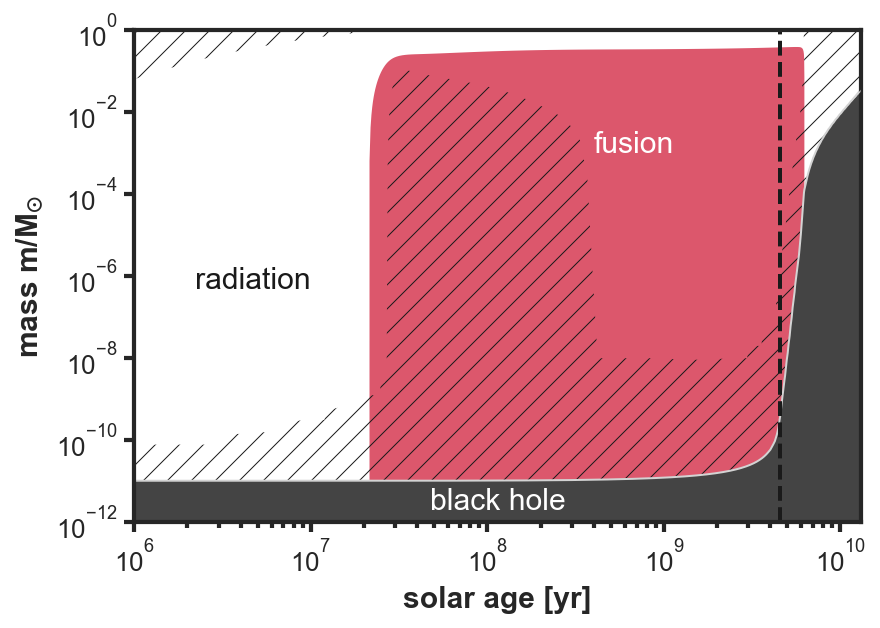

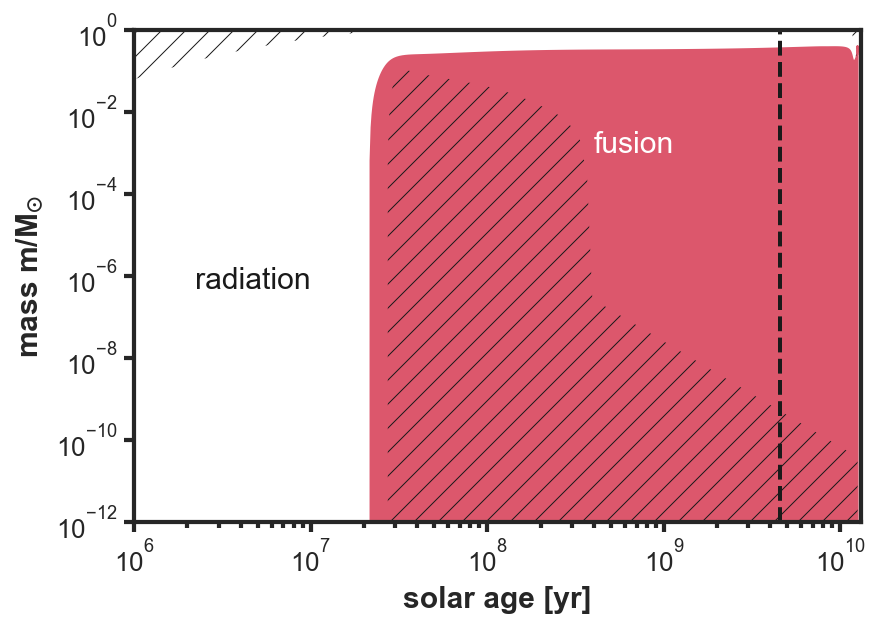

In [11]:
def plot_M(DF, label_fuse=4*10**8, label_rad=True, label_bh=0.025):
    if 'M_BH' not in DF.columns:
        DF['M_BH'] = 0
        DF['M_cav'] = 0
    DF['buffer'] = DF.M_BH + DF.M_cav
    
    plt.figure(figsize=(6.5,4.75))#*1.2))
    
    fusion = "#dc576c"
    bh = "#444444"
    
    burn_type = DF.filter(regex=("burn_type*")).max(axis=1)
    burn_type[burn_type >= 1] = 1
    qtop = DF.filter(regex=("burn_qtop_"))
    qtop[qtop >= 1] = np.nan
    qtop[qtop <  0] = np.nan
    qtop = qtop.max(axis=1)
    qtop[burn_type == 0] = 0
    plt.fill_between(DF['star_age'],
         0, 
         qtop, 
         fc=fusion, alpha=1, ec='face', lw=1)

    ccore = DF[['mx1_bot', 'mx2_bot']].min(axis=1)
    ccore = np.logical_and(ccore < 0.05, ccore > 0)
    plt.fill_between(DF['star_age'].values[ccore],
                     0,
                     DF[['mx1_top', 'mx2_top']][ccore].min(axis=1),
                     hatch='//', ec='k', fc='none', alpha=1, lw=0)
    cenv = DF[['mx1_top', 'mx2_top']].max(axis=1) > 0.99
    plt.fill_between(DF['star_age'].values[cenv],
                     [x if x>1e-6 else 0 for x in DF[['mx1_bot', 'mx2_bot']][cenv].max(axis=1)],
                     1,
                     hatch='//', ec='k', fc='none', alpha=1, lw=0)
    
    if np.any(DF['M_BH']>0):
        plt.fill_between(DF.star_age, DF.M_BH, DF.buffer, color='lightgray', ec='face', lw=0, zorder=100)
        plt.fill_between(DF.star_age, 0, DF.M_BH, color=bh, ec='face', lw=0)
        plt.plot(DF.star_age, DF.buffer, '-', c='lightgray', lw=1)
        
        #plt.axhspan(-1, 1, DF.star_age.max()/13e9, 1, color=bh, zorder=-9999) 
        
        if label_bh>0:
            plt.text(0.5, label_bh, 'black hole', c='w', family='sans-serif', size=15, 
                 transform=plt.gca().transAxes, ha='center')
    
    #plt.text(1.3*10**5, 13*10**-2, 'convection', c='k', family='sans-serif', size=15, 
    #        bbox=dict(facecolor='white', edgecolor='none', pad=0.15, alpha=0.8, boxstyle='round,rounding_size=0.5'))
    
    if label_fuse>0:
        plt.text(label_fuse, 10*10**-4, 'fusion', c='white', family='sans-serif', size=15, 
            bbox=dict(facecolor=fusion, edgecolor='none', pad=0.35, boxstyle='round,rounding_size=0.5'))
    if label_rad:
        plt.text(2.2*10**6, 5*10**-7, 'radiation', c='k', family='sans-serif', size=15, 
            bbox=dict(facecolor='white', edgecolor='none', pad=0.35, boxstyle='round,rounding_size=0.5'))
    plt.axvline(4.572e9, ls='--', c='k')

    plt.semilogx()
    plt.semilogy()
    plt.xlim([10**6, 13e9])
    #plt.ylim([DF.M_BH.values[0]/10, 1])
    plt.ylim([1e-12, 1e0])
    plt.xlabel('solar age [yr]')
    plt.ylabel(r'mass m/M$_{\mathbf{\odot}}$')
    plt.tight_layout()
    #plt.savefig('kippenhahn-full.pdf')
    plt.show()

#plot_M(pd.read_table('pbh_grid/M=1_MBHf=-10_Z=0.02/history.data', skiprows=5, sep='\s+'))
#plot_M(pd.read_table('pbh_grid/M=1_MBHf=-15_Z=0.02/history.data', skiprows=5, sep='\s+'))
#plot_M(pd.read_table('../bhsun/newm/curr/LOGS/history.data', skiprows=5, sep='\s+'))
#plot_M(pd.read_table('../bhsun/normal/LOGS/history.data', skiprows=5, sep='\s+'), False,False)
#plot_M(pd.read_table('pbh_grid/M=1_MBHf=-9_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'), False,False,False)
#plot_M(pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-11_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'))
plot_M(pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-11/LOGS/history.data', skiprows=5, sep='\s+'))
#plot_M(pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-10_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'), label_fuse=2*10**8, label_bh=0.06)
plot_M(pd.read_table('sep_pbh_grid/normal/LOGS/history.data', skiprows=5, sep='\s+'),label_bh=0)

In [12]:
SunDF = pd.read_table('sep_pbh_grid/normal/LOGS/history.data', skiprows=5, sep='\s+')

In [13]:
bot = 'R_B'
mpl.rcParams['hatch.linewidth'] = 0.5
fusion = "#dc576c"
bh = '#444444'

def plot_Msun(DF, label_fuse=4*10**8, label_rad=True, label_conv=1, logy=True):
    DF = DF.copy()
    DF['star_age'] = DF['star_age']/1e9
    DF = DF[DF.star_age < DF.star_age.values[-1]*0.9999]
    #plt.gca().set_rasterization_zorder(-1)
    
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-2, 0, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 11):
        bot  = DF['burn_qtop_' + str(i-1)] if i > 1 else np.zeros(len(DF))
        top  = DF['burn_qtop_' + str(i)]
        burn = DF['burn_type_' + str(i)]
        for j in range(len(Y)-1):
            condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            Z[j, condition] = burn[condition]
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors=fusion, zorder=-999)
    
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-2, 0, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 20):
        bot = DF['mix_qtop_'  + str(i-1)] if i > 1 else np.zeros(len(DF))
        top = DF['mix_qtop_'  + str(i)]
        mix = DF['mix_type_' + str(i)]
        for j in range(len(Y)-1):
            condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            Z[j, condition] = mix[condition]
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors='none', hatches=['//'], zorder=-9)
    
    
    plt.fill_between(DF['star_age'], 0, DF['he_core_mass'], color='#ffffbb', zorder=-9999)
    
    if label_fuse>0:
        plt.text(label_fuse/1e9, 155*10**-3, 'fusion', c='white', family='sans-serif', size=15, 
            bbox=dict(facecolor=fusion, edgecolor='none', pad=0.35, boxstyle='round,rounding_size=0.5'))
    if label_conv>0:
        plt.text(0.8, 5e-9, 'convection', c='k', family='sans-serif', size=15, 
            bbox=dict(facecolor=fusion, edgecolor='none', pad=0.35, boxstyle='round,rounding_size=0.5'))
    plt.axvline(4.572, ls='--', c='k')

    plt.semilogy()
    #plt.xlim([0, DF['star_age'].values[-1]*1.01])
    plt.xlim([0, xmax])
    plt.ylim([0.05, 1e0])
    
    yticks = [0.05, 1e-1, 0.5, 1]
    plt.gca().set_yticks(yticks)
    plt.gca().set_yticklabels(['0.05', '0.1', '0.5', '1'])
    
    plt.xlabel('age [Gyr]')
    plt.ylabel(r'mass m/M$_{\mathbf{\odot}}$')
    plt.tight_layout()




def plot_Rsun(DF, label_fuse=4*10**8, label_rad=True, label_conv=0, logy=True):
    DF = DF.copy()
    DF['star_age'] = DF['star_age']/1e9
    DF = DF[DF.star_age < DF.star_age.values[-1]*0.9999]
    
    R = 10**DF['log_R']
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-4, 3, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 11):
        bot = DF['burn_relr_top_' + str(i-1)]*R if i > 1 else np.zeros(len(DF))
        top = DF['burn_relr_top_' + str(i)]*R
        burn = DF['burn_relr_type_' + str(i)]
        for j in range(len(Y)-1):
            condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            Z[j, condition] = burn[condition]
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors=fusion, zorder=-999)
    
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-4, 3, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 21):
        bot = DF['mix_relr_top_'  + str(i-1)]*R if i > 1 else np.zeros(len(DF))
        top = DF['mix_relr_top_'  + str(i)]*R
        mix = DF['mix_relr_type_' + str(i)]
        for j in range(len(Y)-1):
            condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            Z[j, condition] = mix[condition]
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors='none', hatches=['//'], zorder=-9)
    
    plt.plot(DF['star_age'], 10**DF['log_R'], ls='-', lw=3, c='k', zorder=-99)
    plt.axhline(1, ls='--', c='k')
    plt.axvline(4.572, ls='--', c='k')
    
    plt.fill_between(DF['star_age'], 0, DF['burn_relr_top_1']*R, color='#ffffbb', zorder=-9999)
    plt.text(0.82, 0.9, 'photosphere', c='k', family='sans-serif', size=15, 
             transform=plt.gca().transAxes, ha='center')
    
    #plt.text(1, 12*10**-3, 'fusion', c='white', family='sans-serif', size=15, 
    #    bbox=dict(facecolor=fusion, edgecolor='none', pad=0.35, boxstyle='round,rounding_size=0.5'))
    
    
    if logy: plt.semilogy()
    #plt.xlim([0, DF['star_age'].values[-1]*1.01])
    plt.ylim([1e-3, 100])
    plt.xlim([0, xmax])
    yticks = [0.01, 1, 100]
    plt.gca().set_yticks(yticks)
    plt.gca().set_yticklabels(['0.01', '1', '100'])
    plt.xlabel('age [Gyr]')
    plt.ylabel(r'radius r/R$_{\mathbf{\odot}}$')
    plt.tight_layout()

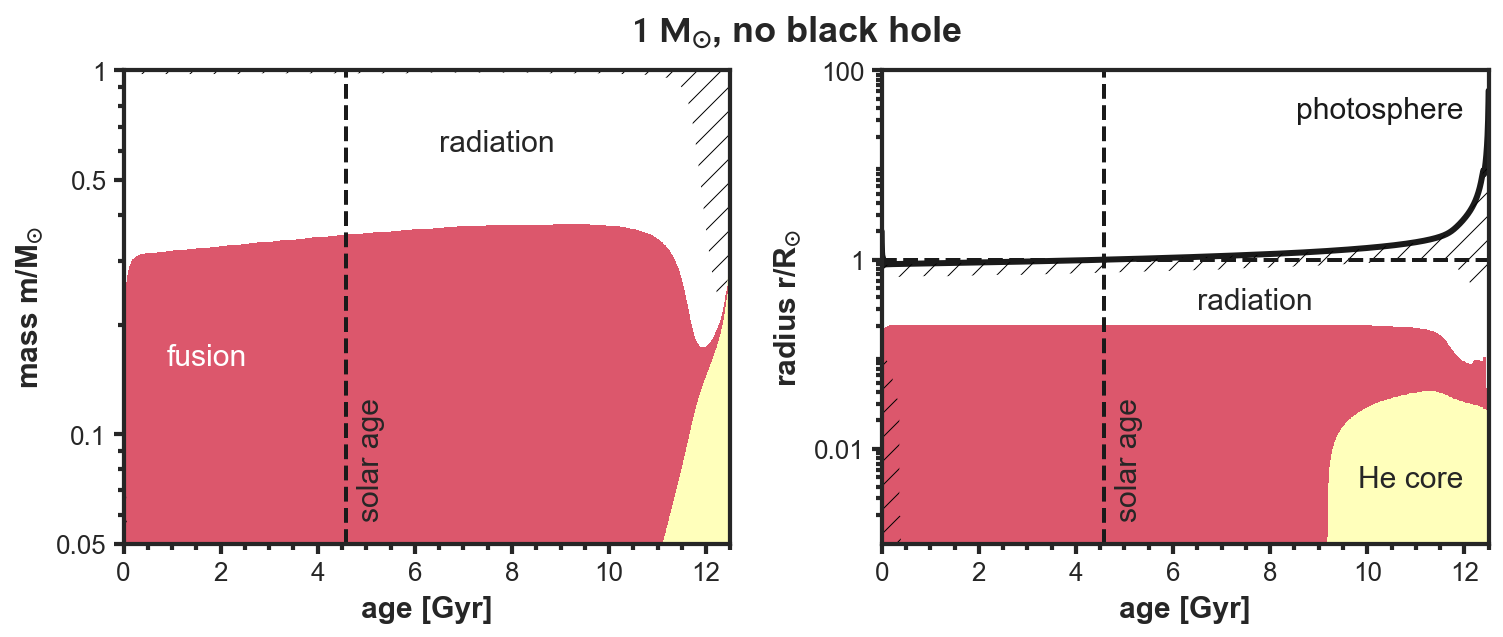

In [14]:
plt.figure(figsize=(10.8, 5))
plt.suptitle(r'$\mathbf{1~M_{\mathbf{\odot}}}$, no black hole', y=0.9, x=0.53, size=18, fontweight='bold')
plt.subplot(121)
plot_Msun(SunDF, label_fuse=0.9*10**9, label_conv=0, logy=False)
plt.text(4.8, 0.06, 'solar age', size=15, rotation=90)
plt.text(6.5, 0.6, 'radiation', size=15)

plt.subplot(122)
plot_Rsun(SunDF)
plt.text(9.8, 0.004, 'He core', size=15)
plt.text(4.8, 0.002, 'solar age', size=15, rotation=90)
plt.text(6.5, 0.3, 'radiation', size=15)
plt.tight_layout()
#plt.savefig('figs/kip-0.pdf')

In [15]:
#m10 = pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-10_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+')
#m11 = pd.read_table('sep_pbh_grid/pradtest/flammang/LOGS/history.data', skiprows=5, sep='\s+')

#m11 = pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-11_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+')
#m11 = pd.read_table('sep_pbh_grid/pradtest/old/LOGS/history.data', skiprows=5, sep='\s+')
m11 = pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-11/LOGS/history.data', skiprows=5, sep='\s+')

In [16]:
def smooth(matrix):
    matrix[matrix<0] = 0
    while True:
        changed = False
        for i in range(1, matrix.shape[0] - 2):
            for j in range(1, matrix.shape[1] - 2):
                if (matrix[i-1, j] == 1) and (matrix[i, j] == 0) and (matrix[i+1, j] == 1):
                    matrix[i, j] = 1
                    changed = True
                if (matrix[i, j-1] == 1) and (matrix[i, j] == 0) and (matrix[i, j+1] == 1):
                    matrix[i, j] = 1
                    changed = True
        for i in range(1, matrix.shape[0] - 3):
            for j in range(1, matrix.shape[1] - 3):
                if (matrix[i-1, j] == 1) and (matrix[i, j] == 0) and (matrix[i+1, j] == 0) and (matrix[i+2, j] == 1):
                    matrix[i, j] = matrix[i+1, j] = 1
                    changed = True
                if (matrix[i, j-1] == 1) and (matrix[i, j] == 0) and (matrix[i, j+1] == 0) and (matrix[i, j+2] == 1):
                    matrix[i, j] = matrix[i, j+1] = 1
                    changed = True
        if not changed:
            break
    return matrix

In [23]:
bot = 'R_B'
mpl.rcParams['hatch.linewidth'] = 0.5
fusion = "#dc576c"
bh = '#444444'

def plot_M(DF, label_fuse=2e9, label_rad=True, label_bh=0.025, label_conv=1, logy=True):
    #plt.gca().set_rasterization_zorder(-1)
    DF = DF.copy()
    if 'M_BH' not in DF.columns:
        DF['M_BH'] = 0
        DF['M_cav'] = 0
    DF['buffer'] = DF.M_BH + DF.M_cav
    
    DF['star_age'] = DF['star_age']/1e9
    DF = DF[DF.star_age < DF.star_age.values[-1]*0.99]
    
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-11, 0, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 11):
        bot  = DF['burn_qtop_' + str(i-1)] if i > 1 else np.zeros(len(DF))
        top  = DF['burn_qtop_' + str(i)]
        burn = DF['burn_type_' + str(i)]
        for j in range(len(Y)-1):
            #condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            #Z[j, condition] = burn[condition]
            final = np.logical_and(Y[j] >= bot, Y[j] < top, burn > 0)
            Z[j, final] = burn[final]
    Z[Z>0] = 1
    Z = smooth(Z)
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors=fusion, zorder=-999)
    
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-12, 3, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 20):
        bot = DF['mix_qtop_'  + str(i-1)] if i > 1 else np.zeros(len(DF))
        top = DF['mix_qtop_'  + str(i)]
        mix = DF['mix_type_' + str(i)]
        for j in range(len(Y)-1):
            #condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            #Z[j, condition] = mix[condition]
            final = np.logical_and(Y[j] >= bot, Y[j] < top, mix > 0)
            Z[j, final] = mix[final]
    Z[Z>0] = 1
    Z = smooth(Z)
    #for i in range(Z.shape[1]):
    #    Z[:, i] = np.where((Y[:, i] >= 0) & (Y[:, i] <= DF['M_BH'].iloc[i]), 1, Z[:, i])
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors='none', hatches=['//'], zorder=-9)
    
    plt.axvline(4.572, ls='--', c='k')
    
    plt.fill_between(DF.star_age, DF.M_BH, DF.buffer, color='lightgray', ec='face', lw=0, zorder=0)
    plt.fill_between(DF.star_age, 0, DF.M_BH, color=bh, ec='face', lw=0, zorder=-1)
    plt.plot(DF.star_age, DF.buffer, '-', c='lightgray', lw=1)
    
    
    if label_bh>0:
        plt.text(0.7, label_bh, 'black hole', c='w', family='sans-serif', size=15, 
             transform=plt.gca().transAxes, ha='center')
    if label_fuse>0:
        plt.text(label_fuse/1e9, 2*10**-6, 'fusion', c='white', family='sans-serif', size=15, 
            bbox=dict(facecolor=fusion, edgecolor='none', pad=0.05, boxstyle='round,rounding_size=0.1'))
    if label_conv>0:
        #plt.text(0.7, 1e-9, 'convection', c='k', family='sans-serif', size=15, #rotation=90, 
        #    bbox=dict(facecolor=fusion, edgecolor='none', pad=0.25, boxstyle='round,rounding_size=0.5'))
        plt.text(7.2, 0.08, 'convection', c='k', family='sans-serif', size=15, #rotation=90, 
            bbox=dict(facecolor='#ffffffdd', edgecolor='none', pad=0.05, boxstyle='round,rounding_size=0.05'))
    
    if logy: plt.semilogy()
    #plt.xlim([0, DF['star_age'].values[-1]])
    plt.xlim([0, xmax])
    plt.ylim([1e-12, 1e0])
    plt.xlabel('age [Gyr]')
    plt.ylabel(r'mass m/M$_{\mathbf{\odot}}$')
    plt.tight_layout()



def plot_R(DF, label_fuse=4*10**8, label_rad=True, label_bh=0.025, label_conv=0, logy=True, bondix=0.5, bondiy=0.05):
    #plt.gca().set_rasterization_zorder(-1)
    DF = DF.copy()
    if 'M_BH' not in DF.columns:
        DF['M_BH'] = 0
        DF['M_cav'] = 0
    if 'R_B' not in DF.columns:
        DF['R_B'] = 0
    DF['buffer'] = DF.M_BH + DF.M_cav
    
    DF['star_age'] = DF['star_age']/1e9
    DF = DF[DF.star_age < DF.star_age.values[-1]*0.99]
    
    DF['R_sch'] = (2 * G * DF['M_BH']*Msun) / c**2 / Rsun
    
    R = 10**DF['log_R']
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-12, 3, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 11):
        bot = DF['burn_relr_top_' + str(i-1)]*R if i > 1 else np.zeros(len(DF))
        top = DF['burn_relr_top_' + str(i)]*R
        burn = DF['burn_relr_type_' + str(i)]
        for j in range(len(Y)-1):
            #condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            #Z[j, condition] = burn[condition]
            final = np.logical_and(Y[j] >= bot, Y[j] < top, burn > 0)
            Z[j, final] = burn[final]
    Z[Z>1] = 1
    Z = smooth(Z)
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors=fusion, zorder=-999)
    
    X, Y = np.meshgrid(DF['star_age'], [0] + list(10**np.linspace(-12, 3, 1000)))
    Z = np.zeros_like(X)
    for i in range(1, 21):
        bot = DF['mix_relr_top_'  + str(i-1)]*R if i > 1 else np.zeros(len(DF))
        top = DF['mix_relr_top_'  + str(i)]*R
        mix = DF['mix_relr_type_' + str(i)]
        for j in range(len(Y)-1):
            #condition = np.logical_and(Y[j] >= bot, Y[j] < top)
            #Z[j, condition] = mix[condition]
            final = np.logical_and(Y[j] >= bot, Y[j] < top, mix > 0)
            Z[j, final] = mix[final]
    for i in range(Z.shape[1]):
        Z[:, i] = np.where((Y[:, i] >= 0) & (Y[:, i] <= DF['R_B'].iloc[i]), 1, Z[:, i])
    Z = smooth(Z)
    Z_masked = np.ma.masked_where(Z <= 0, Z)
    plt.contourf(X, Y, Z_masked, levels=[0, Z_masked.max()], colors='none', hatches=['//'], zorder=-9)
    
    plt.axvline(4.572, ls='--', c='k')
    plt.axhline(1, ls='--', c='k')
    #666666
    plt.plot(DF['star_age'], 10**DF['log_R'], ls='-', c='k', lw=3)
    plt.fill_between(DF.star_age, 0, DF.R_B, color='#bbbbbb', ec='lightgray', lw=1, zorder=-99)
    plt.plot(DF.star_age, DF.R_B, c='lightgray', lw=1, zorder=-9)
    plt.fill_between(DF.star_age, 0, DF.R_sch, color=bh, ec='w', lw=1)
    
    plt.text(bondix, bondiy, 'Bondi radius', c='k', family='sans-serif', size=15, 
             transform=plt.gca().transAxes, ha='center', #rotation=90,
            bbox=dict(facecolor='#bbbbbbdd', edgecolor='none', pad=0.25, boxstyle='round,rounding_size=0.05'))
    plt.text(bondix/1.05, bondiy/8, 'Schwarzschild\nradius', c='w', family='sans-serif', size=15, 
             transform=plt.gca().transAxes, ha='center')
    
    plt.text(0.75, 0.93, 'photosphere', c='k', family='sans-serif', size=15, 
             transform=plt.gca().transAxes, ha='center')
    if label_conv > 0:
        plt.text(0.7, 1e-9, 'convection', c='k', family='sans-serif', size=15, #rotation=90,
            bbox=dict(facecolor=fusion, edgecolor='none', pad=0.25, boxstyle='round,rounding_size=0.5'))
    
    if logy: plt.semilogy()
    #plt.xlim([0, DF['star_age'].values[-1]])
    plt.xlim([0, xmax])
    plt.ylim([1e-12, 1e2])
    plt.ylabel(r'radius r/R$_{\mathbf{\odot}}$')
    plt.xlabel('age [Gyr]')
    plt.tight_layout()

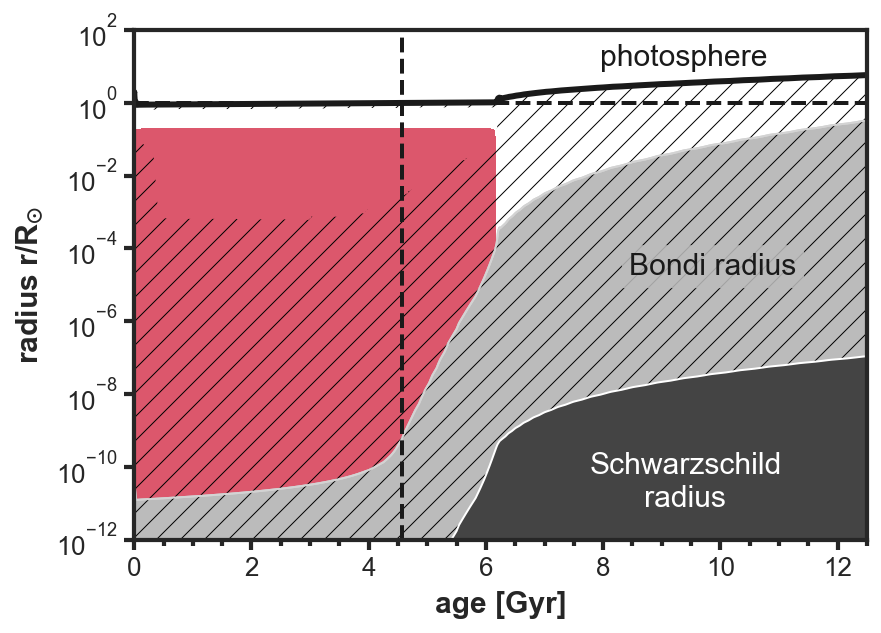

In [24]:
plot_R(m11, 
       label_conv=0, 
       bondix=0.79, bondiy=0.52)

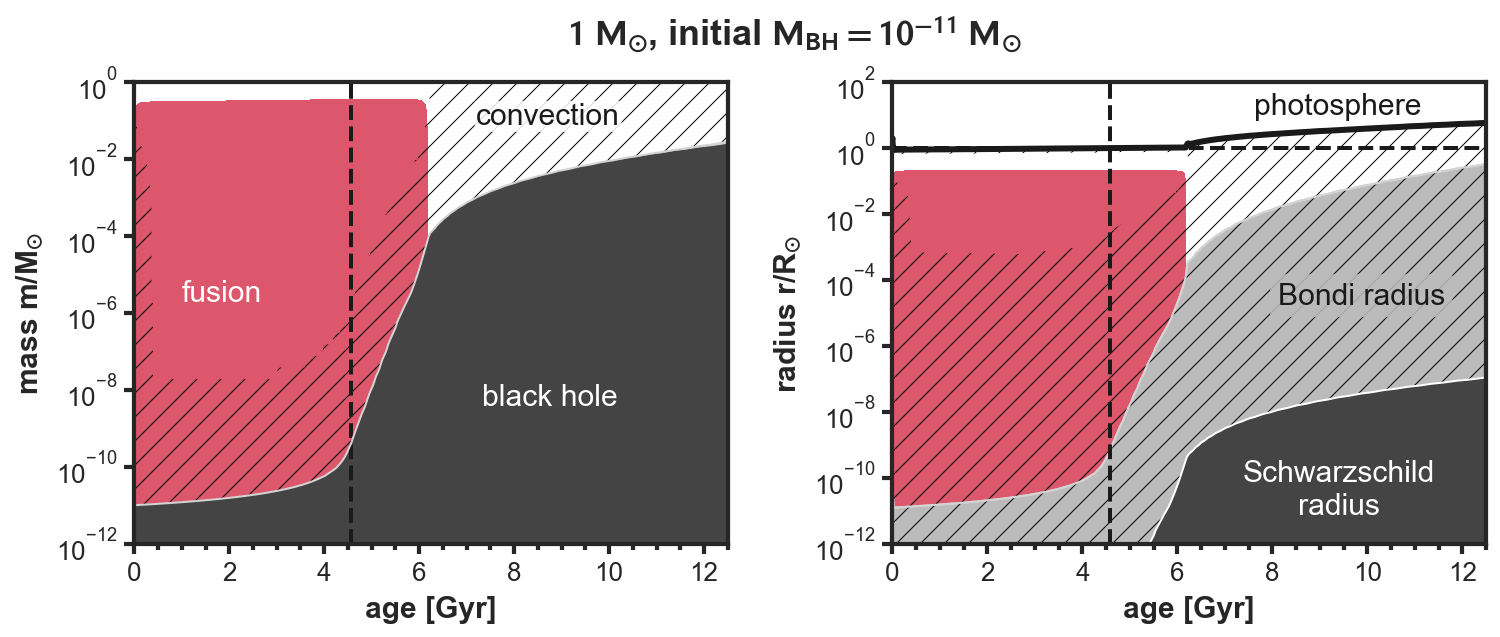

In [25]:
plt.figure(figsize=(10.8, 5))
plt.suptitle(r'$\mathbf{1~M_{\mathbf{\odot}}}$, ' + 
             r'initial $\mathbf{M_{\rm{\mathbf{BH}}} = 10^{-11}~\rm{\mathbf{M}}_{\mathbf{\odot}}}$', 
             y=0.9, x=0.53, size=18, fontweight='bold')
plt.subplot(121)
plot_M(m11, 
       label_bh=0.3, label_fuse=1e9)
plt.subplot(122)
plot_R(m11, 
       label_conv=0, 
       bondix=0.79, bondiy=0.52)
plt.tight_layout()
#plt.savefig('figs/kip-11.pdf')

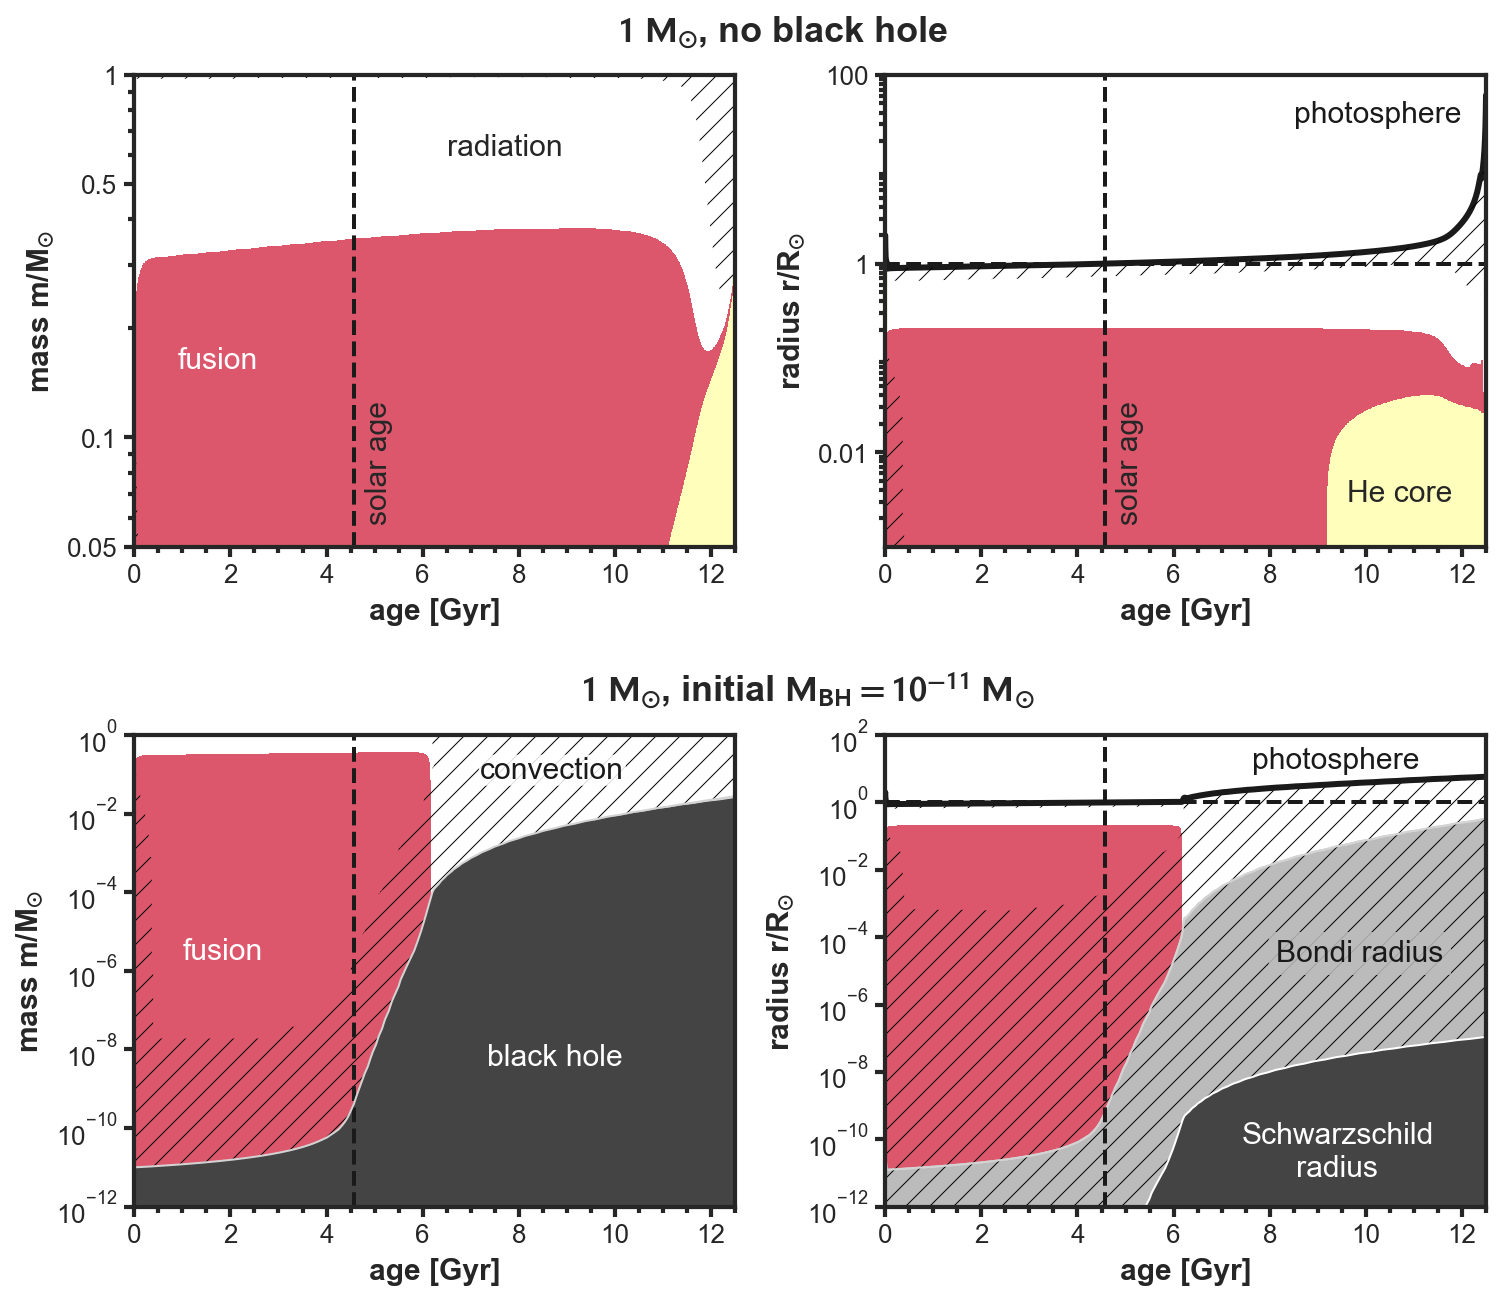

In [26]:
plt.figure(figsize=(10.8, 9.4))

plt.subplot(221)
plt.title(r'$\mathbf{1~M_{\mathbf{\odot}}}$, no black hole', y=1.03, x=1.08, size=18, fontweight='bold')
plot_Msun(SunDF, label_fuse=0.9*10**9, label_conv=0, logy=False)
plt.text(4.8, 0.06, 'solar age', size=15, rotation=90)
plt.text(6.5, 0.6, 'radiation', size=15)
plt.subplot(222)
plot_Rsun(SunDF)
plt.text(9.6, 0.003, 'He core', size=15)
plt.text(4.8, 0.002, 'solar age', size=15, rotation=90)
#plt.text(6.5, 0.3, 'radiation', size=15)

plt.subplot(223)
plt.title(r'$\mathbf{1~M_{\mathbf{\odot}}}$, ' + 
             r'initial $\mathbf{M_{\rm{\mathbf{BH}}} = 10^{-11}~\rm{\mathbf{M}}_{\mathbf{\odot}}}$', 
             y=1.03, x=1.12, size=18, fontweight='bold')
plot_M(m11, label_bh=0.3, label_fuse=1e9)
plt.subplot(224)
plot_R(m11, label_conv=0, bondix=0.79, bondiy=0.52)

plt.tight_layout()

plt.subplots_adjust(wspace=0.25, hspace=0.4)
plt.savefig('figs/kip.pdf')